In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')
    
# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif, datasets, dataset_utils, vae, dft
    from libs.utils import montage
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from libs.datasets import MNIST
ds = MNIST()

print(ds.X.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(70000, 784)


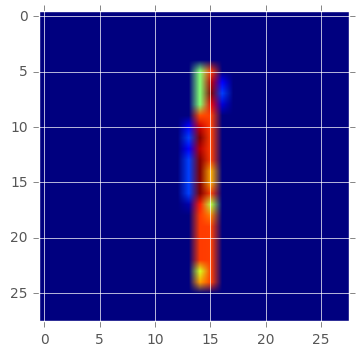

In [2]:
plt.imshow(ds.X[0].reshape((28, 28)))

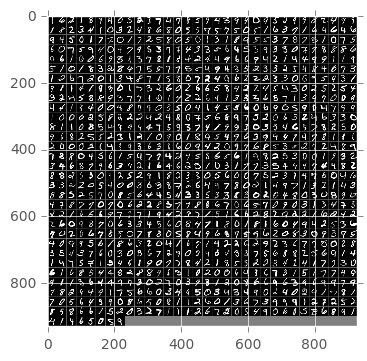

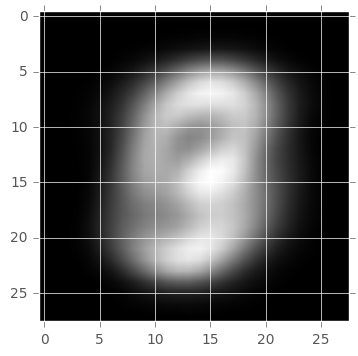

In [3]:
# Let's get the first 1000 images of the dataset and reshape them
imgs = ds.X[:1000].reshape((-1, 28, 28))

# Then create a montage and draw the montage
plt.imshow(montage(imgs), cmap='gray')

# Take the mean across all images
mean_img = np.mean(ds.X, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

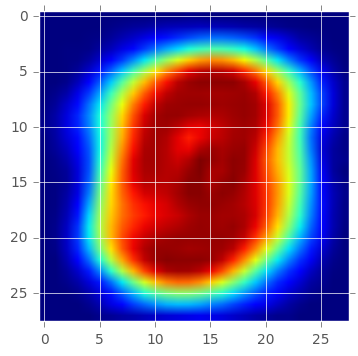

In [4]:
# Take the std across all images
std_img = np.std(ds.X, axis=0)

# Then plot the std image.
plt.figure()
plt.imshow(std_img.reshape((28, 28)))

In [5]:
dimensions = [512, 256, 128, 64]

# So the number of features is the second dimension of our inputs matrix, 784
n_features = ds.X.shape[1]

# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

In [6]:
# let's first copy our X placeholder to the name current_input
current_input = X
n_input = n_features

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output
        
print(current_input.get_shape())

# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

(?, 64)
[128, 256, 512, 784]


In [7]:
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output
        
Y = current_input

# We'll first measure the average difference across every pixel
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

cost = tf.reduce_mean(cost)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?,)


0 0.0401251
1 0.0349953
2 0.032256
3 0.0328159
4 0.0313146


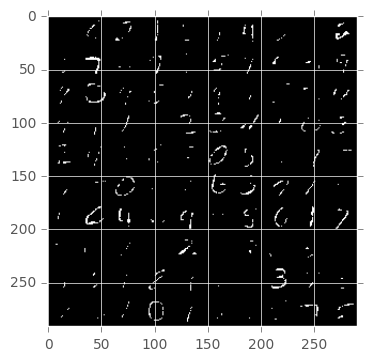

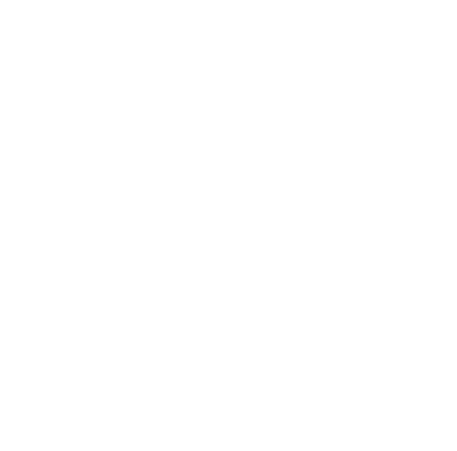

In [8]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [9]:
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),height=250, width=250)

In [10]:
print("Convulutional Autoencoder")

Convulutional Autoencoder


In [11]:
from tensorflow.python.framework.ops import reset_default_graph
reset_default_graph()

# And we'll create a placeholder in the tensorflow graph that will be able to get any number of n_feature inputs.
X = tf.placeholder(tf.float32, [None, n_features])

X_tensor = tf.reshape(X, [-1, 28, 28, 1])

n_filters = [16, 16, 16]
filter_sizes = [4, 4, 4]

In [12]:
current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output
    

In [13]:
# We'll first reverse the order of our weight matrices
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


In [14]:
# and then loop through our convolution filters and get back our input image
# we'll enumerate the shapes list to get us there
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

In [15]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

0 0.0258887
1 0.024727
2 0.0250001
3 0.0244163
4 0.0240606


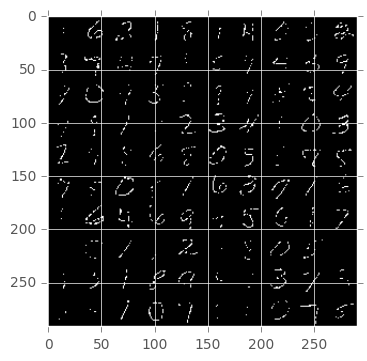

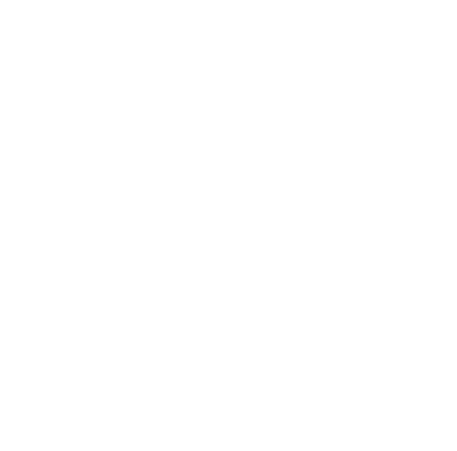

In [16]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001

# pass learning rate and cost to optimize
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Session to manage vars/train
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [17]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),height=250, width=250)

In [18]:
help(vae.VAE)

Help on function VAE in module libs.vae:

VAE(input_shape=[None, 784], n_filters=[64, 64, 64], filter_sizes=[4, 4, 4], n_hidden=32, n_code=2, activation=<function tanh at 0x7f119e455840>, dropout=False, denoising=False, convolutional=False, variational=False)
    (Variational) (Convolutional) (Denoising) Autoencoder.
    
    Uses tied weights.
    
    Parameters
    ----------
    input_shape : list, optional
        Shape of the input to the network. e.g. for MNIST: [None, 784].
    n_filters : list, optional
        Number of filters for each layer.
        If convolutional=True, this refers to the total number of output
        filters to create for each layer, with each layer's number of output
        filters as a list.
        If convolutional=False, then this refers to the total number of neurons
        for each layer in a fully connected network.
    filter_sizes : list, optional
        Only applied when convolutional=True.  This refers to the ksize (height
        and widt